<a href="https://colab.research.google.com/github/apoorvthedude/LGMVIP-DataScience/blob/main/Task_3_Stock_Market_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LetsGrowMore

## Task 3 : Stock Market Prediction And Forecasting Using Stacked LSTM

### Datasetlink:  https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv

## Importing Packages

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
%matplotlib inline

In [2]:
#checking my tensorflow version
tf.__version__

'2.7.0'

## Loading the Dataset

In [3]:
#Import the data and remove rows containing NAN values
df = pd.read_csv('https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv')
df=df. iloc[::-1]
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


In [4]:
df.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35


In [5]:
df.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


#### Data Preprocessing


In [6]:
df.isnull().sum()


Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

In [8]:
df.shape

(2035, 8)

In [9]:
df_high=df.reset_index()['High']


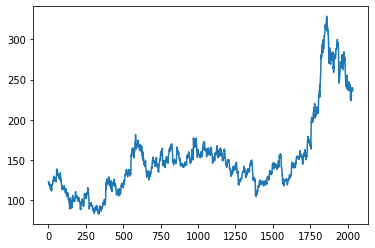

In [10]:
plt.plot(df_high)


Since LSTM are sensitive to the scale of the data, so we apply MinMax Scaler to transform our values between 0 and 1



In [11]:
scaler = MinMaxScaler(feature_range = (0,1))
df_high = scaler.fit_transform(np.array(df_high).reshape(-1,1))

In [12]:
df_high.shape


(2035, 1)

In [13]:
df_high


array([[0.16344786],
       [0.15938199],
       [0.15917869],
       ...,
       [0.6391543 ],
       [0.62614353],
       [0.62268754]])

In [14]:
#Split the data into train and test split
training_size = int(len(df_high) * 0.75)
test_size = len(df_high) - training_size
train_data, test_data = df_high[0:training_size,:], df_high[training_size:len(df_high),:1]

In [15]:
training_size,test_size


(1526, 509)

In [16]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [17]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [18]:
#Reshape the input to be [samples, time steps, features] which is the requirement of LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [19]:
print(x_train.shape), print(y_train.shape)


(1425, 100, 1)
(1425,)


(None, None)

In [20]:
print(x_test.shape), print(y_test.shape)


(408, 100, 1)
(408,)


(None, None)

### Create the LSTM Model


In [21]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
23/23 [==============================] - 13s 282ms/step - loss: 0.0105 - val_loss: 0.0521
Epoch 2/100
23/23 [==============================] - 6s 258ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 3/100
23/23 [==============================] - 6s 257ms/step - loss: 8.0912e-04 - val_loss: 0.0031
Epoch 4/100
23/23 [==============================] - 6s 258ms/step - loss: 7.3067e-04 - val_loss: 0.0038
Epoch 5/100
23/23 [==============================] - 6s 254ms/step - loss: 7.0711e-04 - val_loss: 0.0027
Epoch 6/100
23/23 [==============================] - 6s 257ms/step - loss: 6.8172e-04 - val_loss: 0.0024
Epoch 7/100
23/23 [==============================] - 6s 259ms/step - loss: 6.8795e-04 - val_loss: 0.0028
Epoch 8/100
23/23 [==============================] - 6s 257ms/step - loss: 6.4729e-04 - val_loss: 0.0041
Epoch 9/100
23/23 [==============================] - 6s 257ms/step - loss: 6.1544e-04 - val_loss: 0.0032
Epoch 10/100
23/23 [==============================] - 6s 258ms

In [24]:
#Lets predict and check performance metrics
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [25]:
#Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [26]:
#Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train, train_predict))

136.17905783838606

In [27]:
#Test Data RMSE
math.sqrt(mean_squared_error(y_test, test_predict))

228.59703595302545

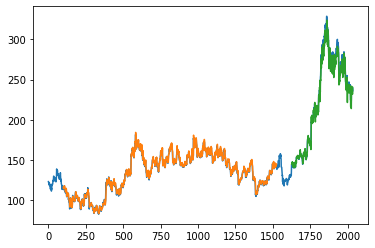

In [28]:
#Plotting

#Shift train prediction for plotting
look_back = 100
trainPredictPlot = np.empty_like(df_high)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

#Shift test prediction for plotting
testPredictPlot = np.empty_like(df_high)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(df_high) - 1, :] = test_predict

#Plot baseline and predictions
plt.plot(scaler.inverse_transform(df_high))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

######>Green indicates the Predicted Data
######>Blue indicates the Complete Data
######>Orange indicates the Train Data

### Predict the next 28 days Stock Price


In [29]:
len(test_data), x_test.shape


(509, (408, 100, 1))

In [30]:
x_input = test_data[409:].reshape(1,-1)
x_input.shape

(1, 100)

In [31]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()


In [32]:
lst_output=[]
n_steps=100
nextNumberOfDays = 28
i=0

while(i<nextNumberOfDays):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.61664283]
101
1 day input [0.86013417 0.85464525 0.84448059 0.8072779  0.71843871 0.66192316
 0.67696686 0.67554381 0.67310429 0.68428542 0.68936776 0.70217524
 0.71803212 0.72941655 0.73144948 0.74486684 0.76926205 0.75991055
 0.74242732 0.73958122 0.74771295 0.75991055 0.7584875  0.76621264
 0.75462492 0.76316324 0.79670665 0.80585485 0.7889815  0.78003659
 0.73978451 0.73002643 0.73490547 0.74872942 0.75991055 0.75462492
 0.75401504 0.76174019 0.7737345  0.82008538 0.80585485 0.81154706
 0.77434438 0.78633869 0.79284407 0.78328929 0.77109169 0.74385038
 0.71193332 0.68733482 0.67818662 0.65257166 0.64301687 0.65643423
 0.67656028 0.67371417 0.65114861 0.65521447 0.66761537 0.67838992
 0.69993901 0.63122586 0.63508843 0.64098394 0.64545639 0.64118723
 0.63854442 0.63081927 0.62472047 0.6330555  0.64728603 0.6574507
 0.66761537 0.66720878 0.64159382 0.62776987 0.63651149 0.63630819
 0.62980281 0.62817646 0.63813783 0.65358813 0.63183574 0.57653995
 0.57816629 0.57613336 0.61943484 

In [33]:
day_new = np.arange(1,101)
day_pred = np.arange(101,129)

In [34]:
day_new.shape


(100,)

In [35]:
day_pred.shape


(28,)

In [36]:
df3 = df_high.tolist()
df3.extend(lst_output)

In [37]:
len(df_high)


2035

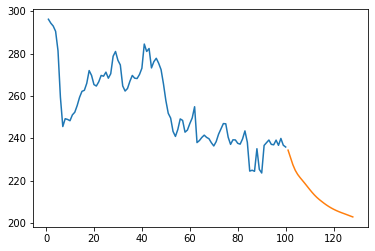

In [38]:
plt.plot(day_new, scaler.inverse_transform(df_high[1935:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

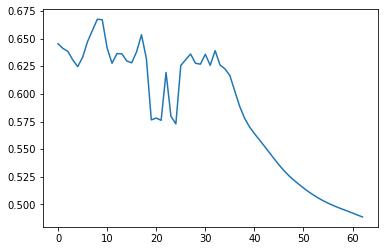

In [39]:
df3=df_high.tolist()
df3.extend(lst_output)
plt.plot(df3[2000:])

In [40]:
df3=scaler.inverse_transform(df3).tolist()


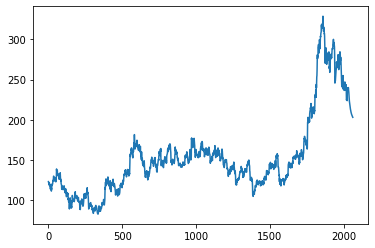

In [41]:
plt.plot(df3)
